# Churn Prediction

**Content:**

- [Introduction](#Introduction)
- [Exploratory analysis](#Exploratory-analysis)
    - [Importing the dataset](#Importing-the-dataset)
    - [Create exploration dataset](#Create-exploration-dataset)
    - [Check correlations with churn](#Check-correlations-with-churn)
    - [Continuous variables](#Continuous-variables)
    - [Categorical variables](#Categorical-variables)
- [Prediction models](#Prediction-models)
    - [Logistic regression](#Logistic-regression)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [Support vector machine](#Support-vector-machine)
- [Conclusion](#Conclusion)

## Introduction

Many companies are in the search for new customers. However, it is also important to keep existing ones. Therefore, companies have incentives to examine whether they need to have a proactive customer retainment strategy. In this project I am going to help the company to select customers that are likely to want to stop using the company's services, by using churn prediction models. 

In this company there are two potential business problems. Both problems need different methods of selecting churn customers.

__Business problem 1:__
The company wants to have a proactive strategy for retaining customers that are very likely to leave. For this, the company wants to implement an email campaign which says something like: "We noticed you may be leaving us. Please don't. Here are several advantages of staying with us." Of course, for this to succeed, we need to target customers who are very likely to leave, but we do not want the other clients to receive these emails.

__Business problem 2:__
To decrease the likelihood of customers leaving the company, the company wants to launch a marketing campaign that targets specifically customers that are likely to leave. This campaign consists of a email with a discount on the next purchase. For this to succeed we want to target customers who are likely to leave the company, but we are not that concerned about other customers receiving the email. However, we do not want to send the email to all customers, as this would be to expensive.

Before going to the building of the classification models and the methods for selecting churn customers, let me first examine the [dataset](https://www.kaggle.com/blastchar/telco-customer-churn) and explore which features are associated with churn.


In [1]:
import os
os.chdir("D:/Projects/churn/")

## Exploratory analysis

### Importing the dataset

In [2]:
# import dependencies for exploratory analysis
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
# import the dataset
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
# show first five observations
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# count and dtype of variables in dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Create exploration dataset

I first will examine which of the features are associated with churn. There are not many features, so I will address all of them. 

It is important to not do this type of analysis on the test set, as this test set will be used to select the best model. I therefore create an exploration dataset which contain the same samples as the dataset that will be used for training the churn prediction models. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["Churn"]), data["Churn"], random_state=42, stratify=data["Churn"])
exploration = X_train.copy().merge(y_train.copy(), left_index=True, right_index=True)

In [7]:
# set TotalCharges to numeric
exploration["TotalCharges"] = pd.to_numeric(exploration["TotalCharges"], errors="coerce")
# drop Customer ID variable
exploration = exploration.drop(columns=["customerID"])

In [8]:
# explore missing values
exploration.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        8
Churn               0
dtype: int64

In [9]:
# for the exploratory analysis I will drop these missing values
exploration = exploration.dropna()

In [10]:
# churn proportion
exploration_churn = exploration["Churn"].value_counts() / exploration["Churn"].size
exploration_churn

No     0.734168
Yes    0.265832
Name: Churn, dtype: float64

About 26 percent of the customers is in the churn category. Let's check the correlations between churn and the other variables.

### Check correlations with churn

In this section I am going to estimate the correlations of the variables with the churn variable. This analysis is informative about whether a variable is a good predictor variable, as large negative or positive correlations indicate a large linear association. However, correlations only measure linear associations. Therefore, if a correlation is low, this does not mean that the variable of interest is not a good prediction variable.

In [11]:
# create dummy variables out of the object dtype variables
exploration_with_dummies = pd.get_dummies(exploration)

In [12]:
exploration_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 6661 to 5639
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            5274 non-null   int64  
 1   tenure                                   5274 non-null   int64  
 2   MonthlyCharges                           5274 non-null   float64
 3   TotalCharges                             5274 non-null   float64
 4   gender_Female                            5274 non-null   uint8  
 5   gender_Male                              5274 non-null   uint8  
 6   Partner_No                               5274 non-null   uint8  
 7   Partner_Yes                              5274 non-null   uint8  
 8   Dependents_No                            5274 non-null   uint8  
 9   Dependents_Yes                           5274 non-null   uint8  
 10  PhoneService_No                          5274

In [13]:
# as no internet service and no phone service are already been captured drop them from correlations analysis
exploration_with_dummies = exploration_with_dummies[[column for column in exploration_with_dummies.columns if not column.endswith("service")]]

<AxesSubplot:>

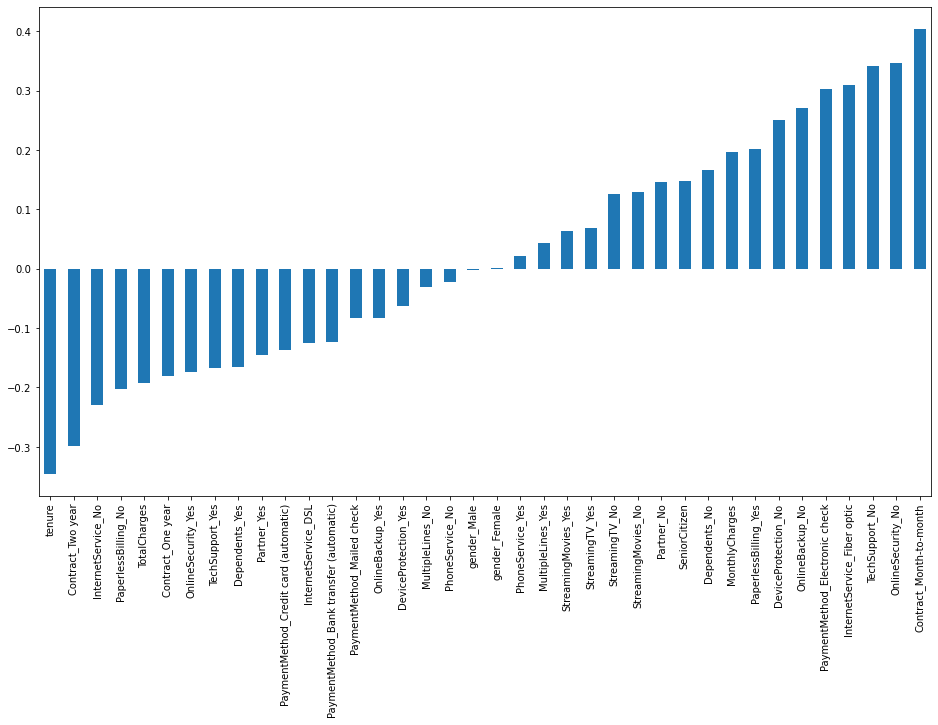

In [14]:
# plot the correlations of the variables with churn
plt.figure(figsize=(16,9))
exploration_with_dummies.corr()["Churn_Yes"].sort_values().drop(["Churn_Yes", "Churn_No"]).plot.bar()

The figure above shows the correlations of all variables with churn. Some variables are very much associated with churn, whereas other correlations are close to or equal to zero. For instance, contract type seems to be very much associated with churn (month to month contracts are positively correlated with churn, two year contracts are negatively associated with churn). And gender seems not to be correlated with churn. 

As the number of variables is small, I am going to use all variables in the prediction models, no matter the size of the correlation coefficients.

### Continuous variables

Let's explore the variables more closely. First, we are going to look at the continuous variables. I am going to explore for each of these variables whether the distributions differ for churn customers compared with not churn customers. Next to the correlation analysis, this distribution comparison analysis is also informative of whether a variable is a good predictor variable.

#### Tenure

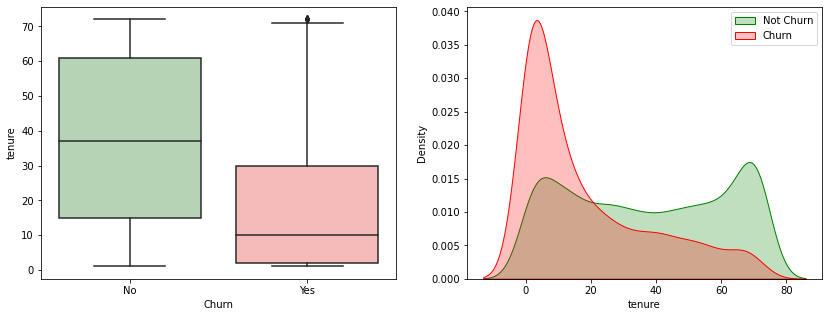

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.boxplot(x=exploration["Churn"], y=exploration["tenure"], palette={"No":"g", "Yes":"r"}, ax=ax1)
for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.kdeplot(data=exploration["tenure"][exploration["Churn"]=="No"], color="green", shade=True, ax=ax2)
sns.kdeplot(data=exploration["tenure"][exploration["Churn"]=="Yes"], color="red", shade=True, ax=ax2)
ax2.legend(["Not Churn", "Churn"])

The figure above shows that the distribution of tenure is very different for churn customers compared with not churn customers. More specifically, the shorter the customers is with the firm, the more likely it is a churn customer. 

#### Total charges

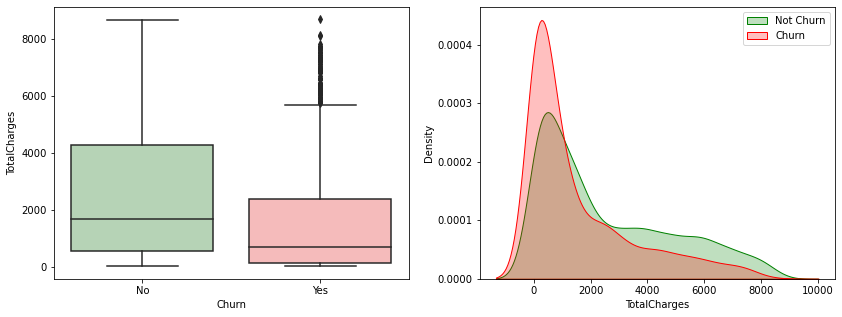

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.boxplot(x=exploration["Churn"], y=exploration["TotalCharges"], palette={"No":"g", "Yes":"r"}, ax=ax1)
for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.kdeplot(data=exploration["TotalCharges"][exploration["Churn"]=="No"], color="green", shade=True, ax=ax2)
sns.kdeplot(data=exploration["TotalCharges"][exploration["Churn"]=="Yes"], color="red", shade=True, ax=ax2)
ax2.legend(["Not Churn", "Churn"])

From the boxplot you can see that there are many outliers in the "yes" category. From the kernel density plot you can see that both distributions are skewed to the right. Let's plot the log transformation for this variable.

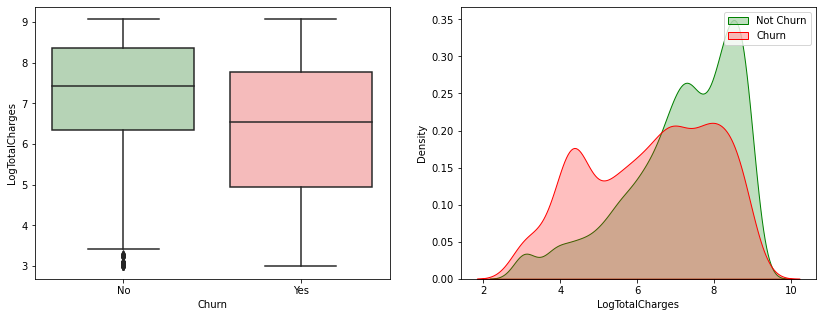

In [17]:
# logtransform the total charges variable

exploration["LogTotalCharges"] = np.log(exploration["TotalCharges"] + 1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.boxplot(x=exploration["Churn"], y=exploration["LogTotalCharges"], palette={"No":"g", "Yes":"r"}, ax=ax1)
for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.kdeplot(data=exploration["LogTotalCharges"][exploration["Churn"]=="No"], color="green", shade=True, ax=ax2)
sns.kdeplot(data=exploration["LogTotalCharges"][exploration["Churn"]=="Yes"], color="red", shade=True, ax=ax2)
ax2.legend(["Not Churn", "Churn"])

Total charges also has a different distribution for each of the two customer groups. The plots above show that those customers that are charged less in total are more likely to be churn customers. 

#### Monthly charges

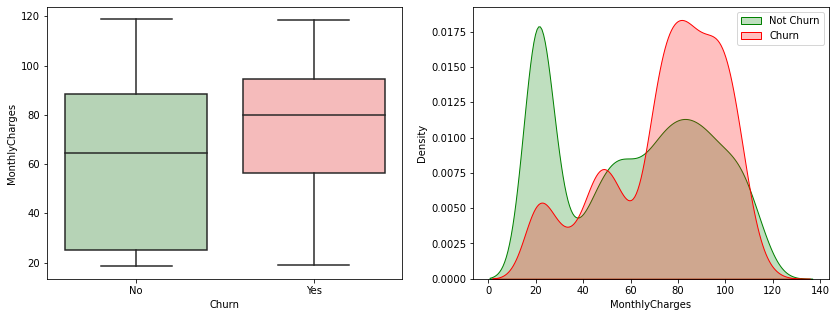

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.boxplot(x=exploration["Churn"], y=exploration["MonthlyCharges"], palette={"No":"g", "Yes":"r"}, ax=ax1)
for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.kdeplot(data=exploration["MonthlyCharges"][exploration["Churn"]=="No"], color="green", shade=True, ax=ax2)
sns.kdeplot(data=exploration["MonthlyCharges"][exploration["Churn"]=="Yes"], color="red", shade=True, ax=ax2)
ax2.legend(["Not Churn", "Churn"])

The plot above shows also an interesting pattern, as the distributions differ. Customers that pay more on a monthly basis are more likely churn customers. A high price therefore seems to be a determinant of leaving the company.

### Categorical variables

Now let's explore the categorical variables. Let's see whether the proportions churn and not churn are different for the categories of the categorical variables, as this might be indicative of whether a variable is a good predictor for churn.

#### Gender

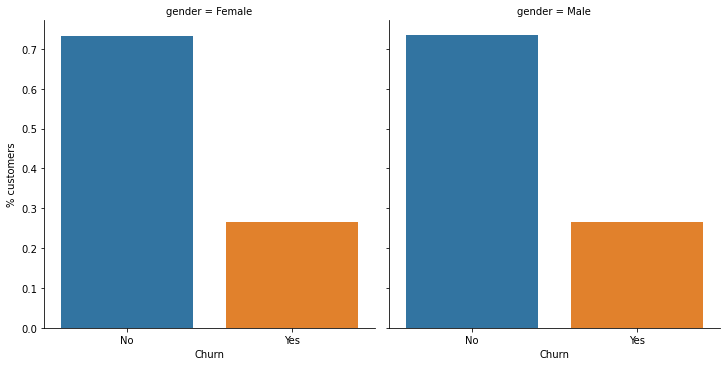

In [19]:
exploration_gender = pd.DataFrame({"% customers": exploration.groupby("gender")["Churn"].value_counts() / exploration.groupby("gender")["gender"].size()})
exploration_gender["Churn"]=exploration_gender.index.get_level_values("Churn")
exploration_gender["gender"]=exploration_gender.index.get_level_values("gender")

sns.catplot(x="Churn", y="% customers", data=exploration_gender, col="gender", kind="bar")

In the plot above, the proportions are similar. Therefore, it seems that gender is not an important predictor for churn. Also from the correlation analysis it appears that gender is not a major predictor for churn. However, it can still mean that there are non-linearities in the data, so we keep the variable in the prediction models.

#### Seniority

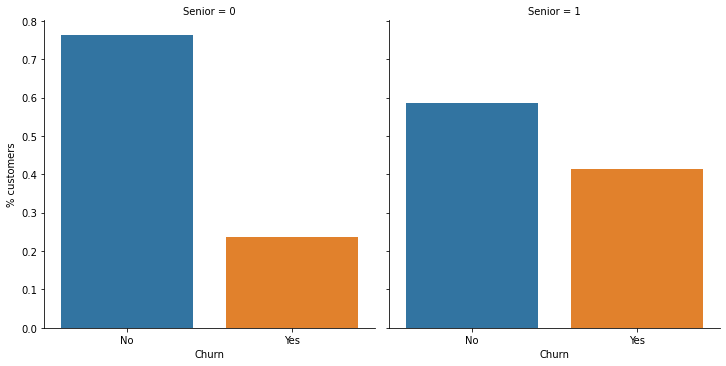

In [20]:
exploration_seniority = pd.DataFrame({"% customers": exploration.groupby("SeniorCitizen")["Churn"].value_counts() / exploration.groupby("SeniorCitizen")["SeniorCitizen"].size()})
exploration_seniority["Churn"]=exploration_seniority.index.get_level_values("Churn")
exploration_seniority["Senior"]=exploration_seniority.index.get_level_values("SeniorCitizen")

sns.catplot(x="Churn", y="% customers", data=exploration_seniority, col="Senior", kind="bar")

As can be seen from the figure above, the proportions churn and not churn are different for the two age groups. More senior customers are more likely to be churn customers.

#### Contract type

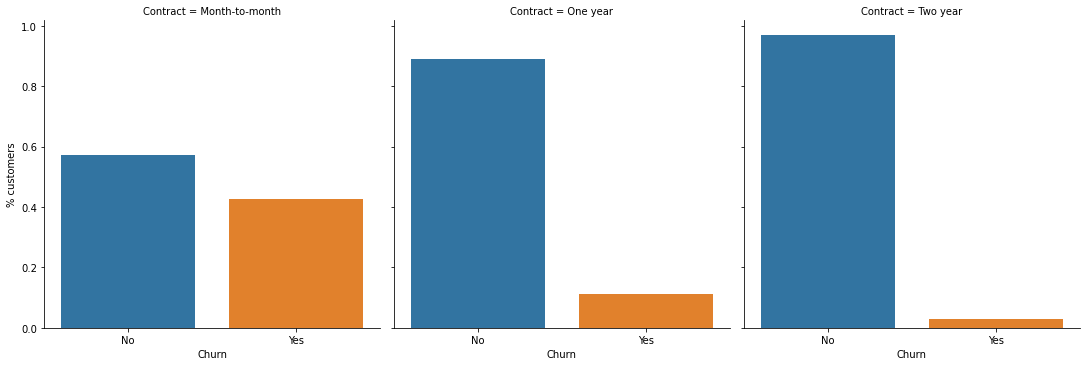

In [21]:
exploration_contract = pd.DataFrame({"% customers": exploration.groupby("Contract")["Churn"].value_counts() / exploration.groupby("Contract")["Contract"].size()})
exploration_contract["Churn"]=exploration_contract.index.get_level_values("Churn")
exploration_contract["Contract"]=exploration_contract.index.get_level_values("Contract")

sns.catplot(y="% customers", x="Churn", col="Contract", data=exploration_contract, kind="bar")

The correlation analysis already showed that contract type is good predictor for churn, and the figure above repeates this idea. Month to month contracts are easily canceled, which makes this variable a logical candidate of a good predictor for churn. Customers with two year contracts are less likely to leave the company.

#### Services

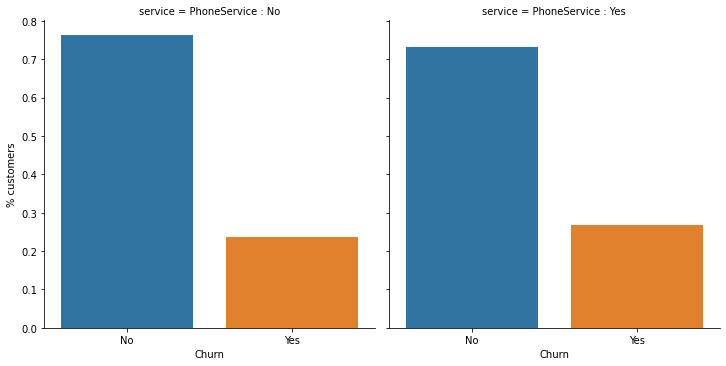

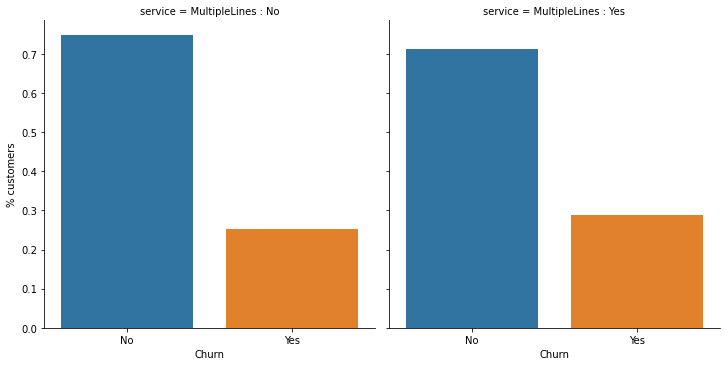

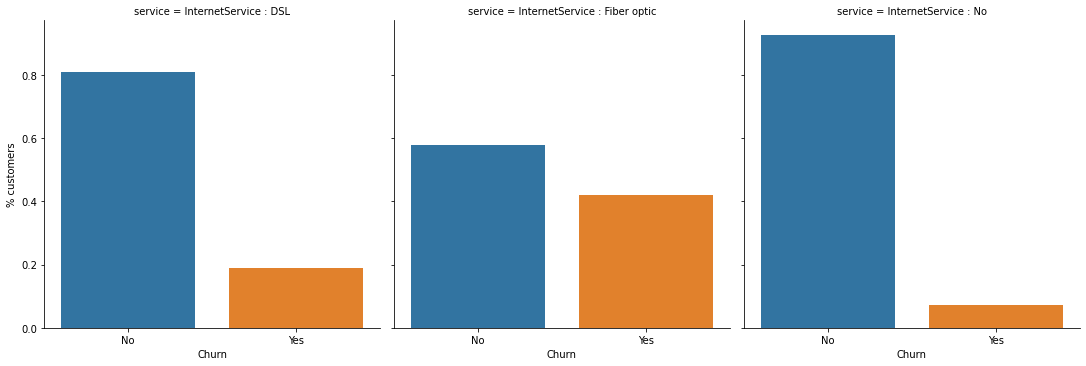

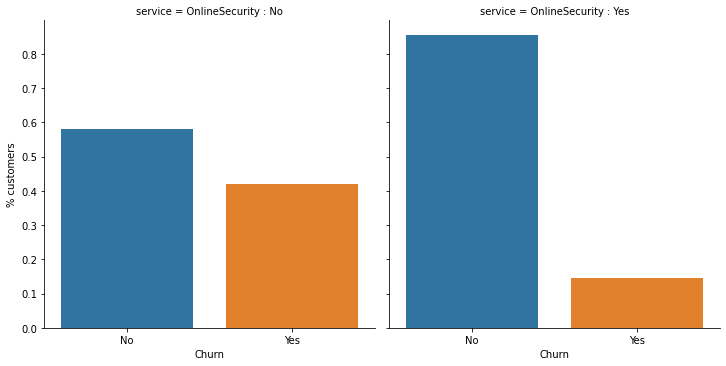

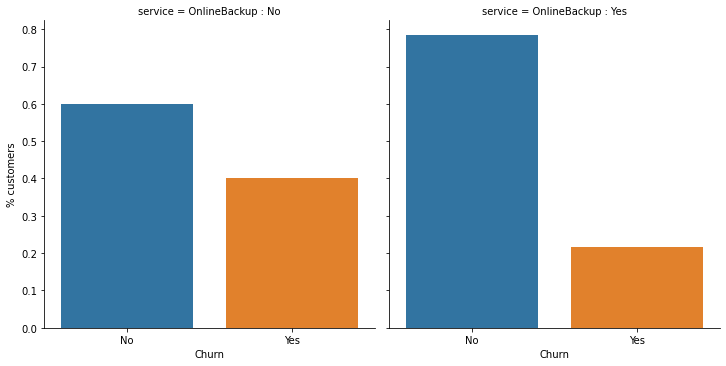

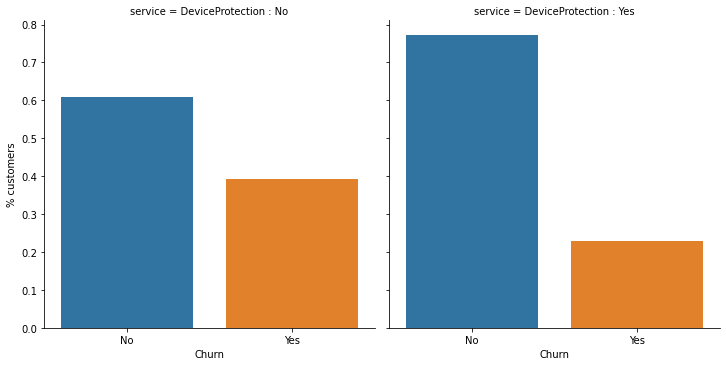

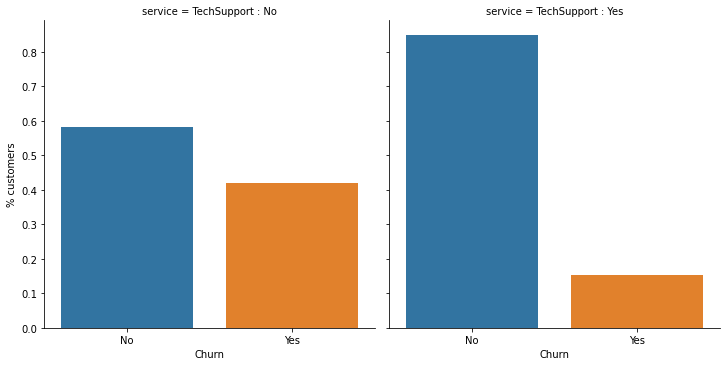

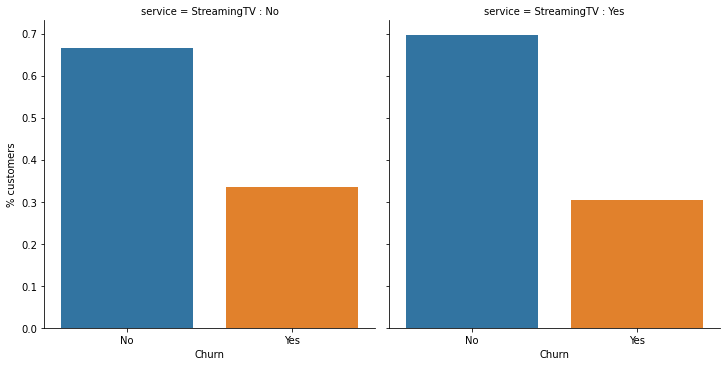

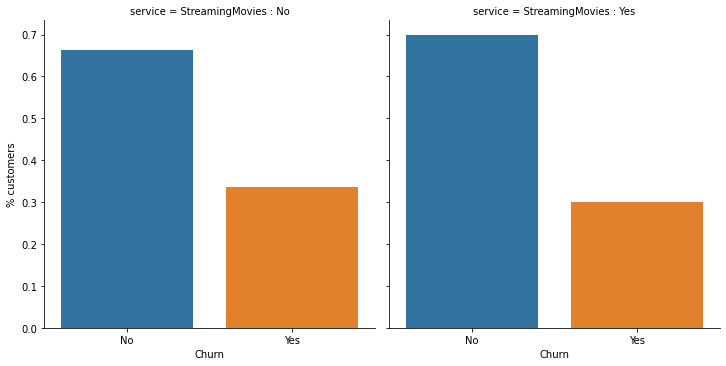

In [22]:
services = ["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

exploration_services = pd.DataFrame()

for i, service in enumerate(services):
    df_service = pd.DataFrame({"% customers": exploration.groupby(service)["Churn"].value_counts() / exploration.groupby(service)[service].size()})
    df_service["service type"] = service
    df_service["service"] = df_service.index.get_level_values(service)
    df_service = df_service[(df_service["service"] != "No internet service") & (df_service["service"] != "No phone service")]
    df_service["service"] = df_service["service type"] + " : " + df_service["service"]
    df_service["Churn"] = df_service.index.get_level_values("Churn")
    exploration_services = pd.concat([exploration_services, df_service])

for service in services:
    sns.catplot(y="% customers", x="Churn", data=exploration_services[exploration_services["service type"]==service], col="service", kind="bar")

The plots above show that the proportions churn - not churn can differ across services, but this depends on the service type. For instance, customers that have tech support are less likely to fall into the churn category than customers with no tech support. But the streaming movies service is not making a large difference. For the prediction models, none of the services will be excluded.

## Prediction models

In this section I am going to use some prediction models in order to identify whether it is possible to have effective email strategies regarding our two business problems. We can identify whether these strategies exist by adjusting classification thresholds.

__Business problem 1:__
Remember that this is an aggressive email campaign. I would suggest to target only a small set of customers who are very likely to leave, as we don't want the customers that are happy and want to stay with the company to be selected for the email campaign. The precision needs to be high; we cannot afford it to have many false positives (customers that are predicted to leave, but are happy and want to stay). Let's choose a model and a classification threshold that gets us to a minimum required precision of 90 percent. That is, if we send an email to 10 customers, then we are allowed to send an email only to one happy customer. Let us see whether this is an attainable strategy.

__Business problem 2:__
This email campaign is less aggressive, but may be expensive if all customers are approached. The company would like to target customers that are likely to leave, but minimize the number of false negatives (customers that are not happy and want to leave, but are predicted to be happy and stay). The recall needs to be sufficiently high. The company accepts a recall of 70 percent, that is, if we send select customers and send them emails, we miss 30 percent of the customer base that we also would like to send an email. We can always choose a classification threshold to achieve this recall of 70 percent, but in order to have an effective campaign, we also would like to have a decent precision. That is, if we only can achieve a precision of 20 percent, then this means that if we send an email to 10 customers, only 2 of those are likely to leave. Let us say, that at a minimum we would like to have a precision of 50 percent and let us see whether this is an atainable strategy. If there is such a strategy, let us then examine whether there is a more optimal one.  

Let us first import some dependencies to be able to build our prediction models.

In [23]:
# import dependencies for the prediction models
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

Below we pre-process the train and test set, and the target variable. 

In [24]:
# preprocessing X train
X_train["TotalCharges"] = pd.to_numeric(X_train["TotalCharges"], errors="coerce")
X_train["LogTotalCharges"] = np.log(X_train["TotalCharges"] + 1)
X_train = X_train.drop(columns=["customerID", "TotalCharges"])

# preprocessing X test
X_test["TotalCharges"] = pd.to_numeric(X_test["TotalCharges"], errors="coerce")
X_test["LogTotalCharges"] = np.log(X_test["TotalCharges"] + 1)
X_test = X_test.drop(columns=["customerID", "TotalCharges"])

In [25]:
# preprocess the target variable
LabelEncoding = LabelEncoder()
LabelEncoding.fit(y_train)
y_train = LabelEncoding.transform(y_train)
y_test = LabelEncoding.transform(y_test)


In [26]:
# The category to be predicted is:
print("The first category to be predicted is '{}'".format(LabelEncoding.classes_[0]))

The first category to be predicted is 'No'


Now, we are going to set up some pipelines and instantiate some classes. These pipelines will be very useful later on. 

In [27]:
# set up pipelines
features_categorical = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", 
                        "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", 
                        "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"]

features_numerical = ["tenure", "MonthlyCharges", "LogTotalCharges", "SeniorCitizen"]

OneHotEncoding = OneHotEncoder(handle_unknown="ignore", sparse=False)
StandardScaling = StandardScaler()

pipeline_categorical = Pipeline([
    ("OneHotEncoding", OneHotEncoding)    
])

pipeline_numerical = Pipeline([
    ("Impute_numerical", SimpleImputer(strategy="median"))
])

pipeline_by_columntype = ColumnTransformer([
    ("cat", pipeline_categorical, features_categorical),
    ("num", pipeline_numerical, features_numerical)
])


As we are going to select different classification thresholds for the two business problems, we need to find the best thresholds based on some data. It can be seen as sort of a hyperparameter, and therefore we cannot use the training set for this. We also cannot use the test dataset for this, as this will be used to compare model outcomes. Instead, we will use the cross validation test sets. As a result, we always want to be sure that a sample is always part of the same set. We therefore implement fixed cross validation test sets when we're doing cross validation.

In [28]:
# implement a fixed cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = list(skf.split(X_train, y_train))
count = 0
test_fold = np.ones(len(X_train), dtype=np.int8) * -1

for train_index, test_index in cv:
    test_fold[test_index] = count
    count += 1
    
ps = PredefinedSplit(test_fold)

To select the right thresholds for the two business problems, I will be using the function below. The function will also plot the precision-recall curve for all of the thresholds.

In [29]:
# generate function to find thresholds and plot recall-precision for the strategies belonging to these thresholds

def find_thresholds(model, threshold_method="predict_proba"):
    if threshold_method=="predict_proba":
        y_proba = cross_val_predict(model, X_train, y_train, cv=ps, method=threshold_method)[:,1]
    else:
        y_proba = cross_val_predict(model, X_train, y_train, cv=ps, method=threshold_method)
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba)
    # default threshold
    predictions_default = cross_val_predict(model, X_train, y_train, cv=ps)
    print(f"The default threshold has a recall of {recall_score(y_train, predictions_default)} and a precision of {precision_score(y_train, predictions_default)}.")
    # find optimal threshold based on optimal f-score
    fscore = (2 * precisions * recalls) / (precisions + recalls)
    ix_optimal = np.argmax(fscore)
    threshold_optimal = thresholds[ix_optimal]
    print(f"The optimal threshold is {threshold_optimal:.3f} and has a recall of {recalls[ix_optimal]:.3f} and a precision of {precisions[ix_optimal]:.3f}.")
    # find threshold belonging to business problem 1
    ix_1 = (np.abs(precisions - 0.9)).argmin()
    threshold1 = thresholds[ix_1]
    print(f"The threshold for business problem 1 is {threshold1:.3f} and has a recall of {recalls[ix_1]:.3f} and a precision of {precisions[ix_1]:.3f}.")
    # find threshold belonging to business problem 2
    ix_2 = (np.abs(recalls - 0.7)).argmin()
    threshold2 = thresholds[ix_2]
    print(f"The threshold for business problem 2 is {threshold2:.3f} and has a recall of {recalls[ix_2]:.3f} and a precision of {precisions[ix_2]:.3f}.")
    
    plt.plot(recalls, precisions, zorder=1)
    plt.scatter(recall_score(y_train, predictions_default), precision_score(y_train, predictions_default), marker="o", color="pink", label="Threshold default", zorder=2)
    plt.scatter(recalls[ix_optimal], precisions[ix_optimal], marker="o", color="purple", label="Threshold optimal", zorder=2)
    plt.scatter(recalls[ix_1], precisions[ix_1], marker="o", color="orange", label="Threshold BS 1", zorder=2)
    plt.scatter(recalls[ix_2], precisions[ix_2], marker="o", color="red", label="Threshold BS 2", zorder=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    

After selecting the appropriate thresholds for our problems, I am going to print some performance metrics on the test set. These will be used in the end to select the best model.

In [30]:
# Generate function to print some performance metrics for selected thresholds on the test set

def print_metrics_testset(model, threshold_optimal, threshold1, threshold2, threshold_method="predict_proba"):
    if threshold_method=="predict_proba":
        predict_probas = model.predict_proba(X_test)[:,1]
    else:
        predict_probas = model.decision_function(X_test)
    predictions_default = model.predict(X_test)
    predictions_optimal = (predict_probas >= threshold_optimal).astype("int")
    predictions1 = (predict_probas >= threshold1).astype("int")
    predictions2 = (predict_probas >= threshold2).astype("int")
    print("Default threshold:")
    print("Threshold: default")
    print(f"Proportion predicted churn: {predictions_default.mean():.3f}")
    print(f"Accuracy: {accuracy_score(y_test, predictions_default):.3f}")
    print(f"Precision: {precision_score(y_test, predictions_default):.3f}")
    print(f"Recall: {recall_score(y_test, predictions_default):.3f}")
    print(f"f-score: {f1_score(y_test, predictions_default):.3f}\n")
    print("Optimal threshold:")
    print(f"Threshold: {threshold_optimal:.3f}")
    print(f"Proportion predicted churn: {predictions_optimal.mean():.3f}")
    print(f"Accuracy: {accuracy_score(y_test, predictions_optimal):.3f}")
    print(f"Precision: {precision_score(y_test, predictions_optimal):.3f}")
    print(f"Recall: {recall_score(y_test, predictions_optimal):.3f}")
    print(f"f-score: {f1_score(y_test, predictions_optimal):.3f}\n")    
    print("Threshold for business problem 1:")
    print(f"Threshold: {threshold1:.3f}")
    print(f"Proportion predicted churn: {predictions1.mean():.3f}")
    print(f"Accuracy: {accuracy_score(y_test, predictions1):.3f}")
    print(f"Precision: {precision_score(y_test, predictions1):.3f}")
    print(f"Recall: {recall_score(y_test, predictions1):.3f}")
    print(f"f-score: {f1_score(y_test, predictions1):.3f}\n")
    print("Threshold for business problem 2:")
    print(f"Threshold: {threshold2:.3f}")
    print(f"Proportion predicted churn: {predictions2.mean():.3f}")
    print(f"Accuracy: {accuracy_score(y_test, predictions2):.3f}")
    print(f"Precision: {precision_score(y_test, predictions2):.3f}")
    print(f"Recall: {recall_score(y_test, predictions2):.3f}")
    print(f"f-score: {f1_score(y_test, predictions2):.3f}") 

### Logistic regression

The first model we are going to examine is logistic regression. First we set up the final logistic regression pipeline, then we fit the model, and then we are going to find the classification thresholds belonging to the business strategies. 

In [31]:
# set up logistic regression pipeline

LogReg = LogisticRegression(max_iter=300)

pipeline_logreg = Pipeline([
    ("preprocessing", pipeline_by_columntype),
    ("scaler", StandardScaler()),
    ("Logreg", LogReg)
])

In [32]:
# fit the logistic regression model
pipeline_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('OneHotEncoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                        

The default threshold has a recall of 0.5392296718972895 and a precision of 0.672.
The optimal threshold is 0.319 and has a recall of 0.746 and a precision of 0.565.
The threshold for business problem 1 is 0.884 and has a recall of 0.025 and a precision of 0.897.
The threshold for business problem 2 is 0.354 and has a recall of 0.700 and a precision of 0.581.


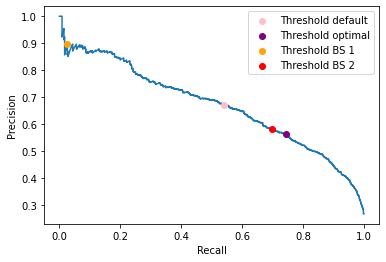

In [33]:
find_thresholds(pipeline_logreg)

In [34]:
print_metrics_testset(pipeline_logreg, 0.319, 0.884, 0.354)

Default threshold:
Threshold: default
Proportion predicted churn: 0.210
Accuracy: 0.806
Precision: 0.670
Recall: 0.531
f-score: 0.593

Optimal threshold:
Threshold: 0.319
Proportion predicted churn: 0.359
Accuracy: 0.776
Precision: 0.558
Recall: 0.756
f-score: 0.642

Threshold for business problem 1:
Threshold: 0.884
Proportion predicted churn: 0.004
Accuracy: 0.738
Precision: 0.857
Recall: 0.013
f-score: 0.025

Threshold for business problem 2:
Threshold: 0.354
Proportion predicted churn: 0.329
Accuracy: 0.786
Precision: 0.578
Recall: 0.717
f-score: 0.640


As you can see, the default threshold 0.5 is not the most optimal threshold for our purposes, and the threshold for busines problem 2 is very close to the optimal threshold. With respect to our business problems:

**Business problem 1:** It is always possible to have a classifier with a specific recall, in our case 0.9, which you can see from the precision-recall plot. However, in our case this strategy is not feasible as the proportion of selected customers for the email campaign is only 0.004. Such a small targeted group might not be worth the effort of the campaign.

**Business problem 2:** For this strategy the company targets a recall of 70 percent, but with a precision level of at least 50 percent. In fact, the precision level belonging to this strategy is almost 60 percent. This strategy therefore seems to be attainable. It is also very close to the optimal strategy.

### Random Forest Classifier

Now we are going to examine a Random Forest model. First, we are going to select the best hyperparameters. Then we are going to find the classification thresholds belonging to the business strategies.

In [35]:
# set up random forest classifier pipeline and parameter grid

RandomForest = RandomForestClassifier(n_jobs=-1, random_state=42)

pipeline_randomforest = Pipeline([
    ("preprocessing", pipeline_by_columntype),
    ("Randomforest", RandomForest)
])

param_grid = [
    {"Randomforest__n_estimators": [500, 1000, 1500, 2000], 
     "Randomforest__max_depth": [5,10,15,20,25, 30]
    }
]

In [36]:
grid_search_randomforest = GridSearchCV(pipeline_randomforest, param_grid, cv=ps, scoring= "f1", return_train_score=True) 

In [37]:
# fit the model
grid_search_randomforest.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([2, 3, ..., 4, 4])),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('OneHotEncoding',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['gender',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines

In [38]:
# top 5 grid search results
cvres = grid_search_randomforest.cv_results_
pd.DataFrame({"f1_score":cvres["mean_test_score"], "params": cvres["params"]}).sort_values(by="f1_score", ascending=False).head(5).values

array([[0.5722895663286822,
        {'Randomforest__max_depth': 10, 'Randomforest__n_estimators': 500}],
       [0.5689903455821019,
        {'Randomforest__max_depth': 10, 'Randomforest__n_estimators': 1000}],
       [0.5687065609987852,
        {'Randomforest__max_depth': 10, 'Randomforest__n_estimators': 1500}],
       [0.5685451759897132,
        {'Randomforest__max_depth': 10, 'Randomforest__n_estimators': 2000}],
       [0.5593760598680593,
        {'Randomforest__max_depth': 15, 'Randomforest__n_estimators': 500}]],
      dtype=object)

In [39]:
# set up final pipeline with the best hyperparameters
RandomForestFinal = RandomForestClassifier(n_jobs=-1, oob_score=True, max_depth=grid_search_randomforest.best_params_["Randomforest__max_depth"], n_estimators=grid_search_randomforest.best_params_["Randomforest__n_estimators"], random_state=42)

pipeline_randomforest_final = Pipeline([
    ("preprocessing", pipeline_by_columntype),
    ("Randomforest", RandomForestFinal)
])

In [40]:
# fit the final pipeline
pipeline_randomforest_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('OneHotEncoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                        

The default threshold has a recall of 0.5035663338088445 and a precision of 0.6629107981220658.
The optimal threshold is 0.329 and has a recall of 0.731 and a precision of 0.556.
The threshold for business problem 1 is 0.831 and has a recall of 0.045 and a precision of 0.900.
The threshold for business problem 2 is 0.350 and has a recall of 0.700 and a precision of 0.567.


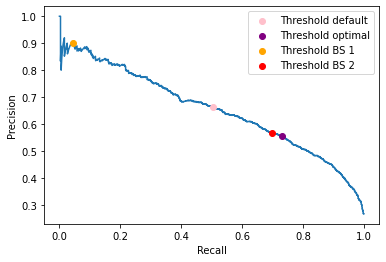

In [41]:
find_thresholds(pipeline_randomforest_final)

In [42]:
print_metrics_testset(pipeline_randomforest_final, 0.329, 0.831, 0.350)

Default threshold:
Threshold: default
Proportion predicted churn: 0.198
Accuracy: 0.801
Precision: 0.667
Recall: 0.497
f-score: 0.569

Optimal threshold:
Threshold: 0.329
Proportion predicted churn: 0.354
Accuracy: 0.772
Precision: 0.553
Recall: 0.739
f-score: 0.632

Threshold for business problem 1:
Threshold: 0.831
Proportion predicted churn: 0.015
Accuracy: 0.746
Precision: 0.852
Recall: 0.049
f-score: 0.093

Threshold for business problem 2:
Threshold: 0.350
Proportion predicted churn: 0.334
Accuracy: 0.772
Precision: 0.556
Recall: 0.700
f-score: 0.620


Also for the Random Forest model, the default threshold is not the optimal threshold. With respect to our business problems:

**Business problem 1:** The precision on the test set is close to 90 percent. However, as you can see in the figure, the precision-recall curve is quite bumpy around the threshold for this problem: it seems difficult to be sure that at least 90 percent is obtained. Also the number of targeted customers is small, although it is somewhat higher than under logistic regression. As this strategy might not lead to a stable precision, and the group of targeted customers is small, the company might not wish to pursue this strategy.

**Business problem 2:** This seems to be an attainable strategy. The recall is 70 percent and the precision is above 50 percent. The results are very comparable with logistic regression.

### Support vector machine

In [43]:
# set up support vector machine pipeline and parameter grid

SupportVectorClassification = SVC()

pipeline_svm = Pipeline([
    ("preprocessing", pipeline_by_columntype),
    ("scaling", StandardScaler()),
    ("Supportvectormachine", SupportVectorClassification)
])

param_grid = [
    {"Supportvectormachine__kernel": ["linear"], 
     "Supportvectormachine__C": [0.01, 0.1, 1, 10, 50]
    },
    {"Supportvectormachine__kernel": ["poly"],
     "Supportvectormachine__degree": [2,3,4,5],
     "Supportvectormachine__C": [0.01, 0.1, 1,10,50]
    },
    {"Supportvectormachine__kernel": ["rbf"],
     "Supportvectormachine__gamma": [0.1, 1, 5, 10],
     "Supportvectormachine__C": [0.01, 0.1, 1, 10, 50]
    }
]

In [44]:
grid_search_svm = GridSearchCV(pipeline_svm, param_grid, cv=ps, scoring="f1", return_train_score=True)

In [45]:
# fit the model
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([2, 3, ..., 4, 4])),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('OneHotEncoding',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['gender',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines

In [46]:
# top 5 grid search results
cvres = grid_search_svm.cv_results_
pd.DataFrame({"f1_score":cvres["mean_test_score"], "params": cvres["params"]}).sort_values(by="f1_score", ascending=False).head(5).values

array([[0.5964795482891397,
        {'Supportvectormachine__C': 0.01, 'Supportvectormachine__kernel': 'linear'}],
       [0.5913904700749286,
        {'Supportvectormachine__C': 0.1, 'Supportvectormachine__kernel': 'linear'}],
       [0.5889951242753668,
        {'Supportvectormachine__C': 50, 'Supportvectormachine__kernel': 'linear'}],
       [0.5887748499850052,
        {'Supportvectormachine__C': 10, 'Supportvectormachine__kernel': 'linear'}],
       [0.587587276057299,
        {'Supportvectormachine__C': 1, 'Supportvectormachine__kernel': 'linear'}]],
      dtype=object)

In [47]:
# search for better hyperparameters
param_grid2 = [{
    "Supportvectormachine__kernel":["linear"],
    "Supportvectormachine__C": [0.0001, 0.001, 0.01, 0.02, 0.05]
}]

grid_search_svm2 = GridSearchCV(pipeline_svm, param_grid2, cv=ps, scoring="f1", return_train_score=True)

grid_search_svm2.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([2, 3, ..., 4, 4])),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('OneHotEncoding',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['gender',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines

In [48]:
# top 5 grid search results
cvres = grid_search_svm2.cv_results_
pd.DataFrame({"f1_score":cvres["mean_test_score"], "params": cvres["params"]}).sort_values(by="f1_score", ascending=False).head(5).values

array([[0.5964795482891397,
        {'Supportvectormachine__C': 0.01, 'Supportvectormachine__kernel': 'linear'}],
       [0.5931011256528442,
        {'Supportvectormachine__C': 0.02, 'Supportvectormachine__kernel': 'linear'}],
       [0.5919487199554361,
        {'Supportvectormachine__C': 0.05, 'Supportvectormachine__kernel': 'linear'}],
       [0.5571929965706623,
        {'Supportvectormachine__C': 0.001, 'Supportvectormachine__kernel': 'linear'}],
       [0.0,
        {'Supportvectormachine__C': 0.0001, 'Supportvectormachine__kernel': 'linear'}]],
      dtype=object)

In [49]:
# set up final support vector machine pipeline
SupportVectorClassification_final = SVC(kernel="linear", C=0.01)

pipeline_svm_final = Pipeline([
    ("preprocessing", pipeline_by_columntype),
    ("scaling", StandardScaler()),
    ("Supportvectormachine", SupportVectorClassification_final)    
])

pipeline_svm_final.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('OneHotEncoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                        

The default threshold has a recall of 0.5299572039942939 and a precision of 0.6835326586936522.
The optimal threshold is -0.624 and has a recall of 0.735 and a precision of 0.564.
The threshold for business problem 1 is 1.250 and has a recall of 0.058 and a precision of 0.900.
The threshold for business problem 2 is -0.549 and has a recall of 0.700 and a precision of 0.577.


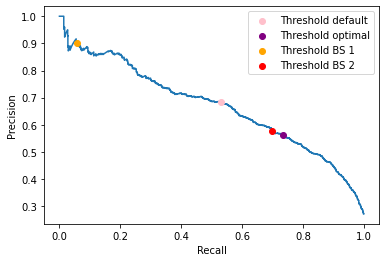

In [50]:
find_thresholds(pipeline_svm_final, threshold_method="decision_function")

In [51]:
print_metrics_testset(pipeline_svm_final, -0.624, 1.250, -0.549, threshold_method="decision_function")

Default threshold:
Threshold: default
Proportion predicted churn: 0.206
Accuracy: 0.806
Precision: 0.672
Recall: 0.522
f-score: 0.588

Optimal threshold:
Threshold: -0.624
Proportion predicted churn: 0.351
Accuracy: 0.775
Precision: 0.557
Recall: 0.737
f-score: 0.634

Threshold for business problem 1:
Threshold: 1.250
Proportion predicted churn: 0.017
Accuracy: 0.746
Precision: 0.833
Recall: 0.054
f-score: 0.101

Threshold for business problem 2:
Threshold: -0.549
Proportion predicted churn: 0.336
Accuracy: 0.782
Precision: 0.570
Recall: 0.722
f-score: 0.637


Also for the support vector machine, the default threshold is not the optimal threshold. With respect to our business problems:

**Business problem 1:** The precision on the test set is about 83 percent. Also here the precision-recall curve is quite bumpy around the threshold for this problem: it seems difficult to be sure that at least 90 percent is obtained. Also the number of targeted customers is small, although it is somewhat higher than under logistic regression. As this strategy might not lead to a stable precision, and the group of targeted customers is small, the company might not wish to pursue this strategy.

**Business problem 2:** This seems to be an attainable strategy. The recall is 70 percent and the precision is above 50 percent. The results are very comparable with logistic regression and the random forest model.

# Conclusion

This project shows that depending on the business problem at hand, one should select the right performance metrics and targets, and find the best classification threshold.

In this project I used three models (logistic regression, random forest classification, and support vector machines) to examine whether two email campaigns could be effective. It seems that the model choice is not so important: all three models generate similar recall-precision trade-offs. However, the classificaton threshold selection is important for the two email campaigns.

With respect to the two business problems:
- The email campaign for the first business problem is not a good idea. It could be very difficult to guarantee that the required precision is attained. Furthermore, the predicted churn customers is a very small group, not worth the effort of an agressive email campaign.
- The email campaign for the second business problem is a good idea, if the manager would agree with a precision between 50 and 60 percent. Model choice does not seem to matter, but the selection of the right threshold does matter.

